## 6. Neural Scaling 
- A number of scaling plots in this chapter are "reverse engineered" from a very central figure in the GPT-3 paper
- This notebook shows this process for completeness. 

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from tqdm import tqdm
from matplotlib.transforms import Bbox

In [17]:
# Load in plot from GPT-3 paper
im = cv2.imread("data/LanguageModelingComputePareto.png")[:, :, (2, 1, 0)]

In [8]:
# Manually code up info from plot
plot_corners = [[114, 380], [1520, 380], [1520, 1913], [114, 1914]]
xmin = 1e-6
xmax = 1e4
ymin = 1.5
ymax = 6

colors = np.array(
    [
        [62, 8, 81],  # 0
        [67, 35, 111],
        [64, 78, 134],
        [63, 104, 138],
        [64, 115, 139],  # 4
        [66, 123, 140],  # 5
        [68, 135, 140],
        [75, 155, 138],
        [84, 169, 133],  # 8
        [93, 178, 127],  # 9
        [103, 188, 116],  # [106,189,119], #10
        [131, 203, 105],
        [152, 210, 95],
        [250, 232, 85],
    ]
)
matching_thresh = [
    25,  # 0
    25,
    25,
    15,
    15,
    15,
    20,
    25,
    25,  # 8
    20,  # 9
    22,  # 10
    25,
    18,  # 12
    25,
]

In [9]:
# Search for matching colors
all_matches = []
for color_index in range(len(colors)):
    matches = []
    for col_index in np.arange(plot_corners[0][1], plot_corners[2][1]):
        distance_to_color = np.sum(
            abs(im[:, col_index].astype("float") - colors[color_index].astype("float")),
            1,
        )
        # distance_to_color=np.linalg.norm(abs(im[:, col_index].astype('float')-colors[color_index].astype('float')), axis=1)
        if np.min(distance_to_color) < matching_thresh[color_index]:
            matching_row = np.argmin(distance_to_color)
            matches.append([col_index, matching_row])
    matches = np.array(matches)
    all_matches.append(matches)

In [10]:
assumed_parameter_counts = [
    1e5,
    5e5,
    1e6,
    4e6,
    13e6,
    40e6,
    125e6,  # These are from the paper
    350e6,
    760e6,
    1.3e9,
    2.7e9,
    6.7e9,
    12e9,
    175e9,
]

cmap = cm.get_cmap("viridis")
min_val = np.log10(assumed_parameter_counts[0])
max_val = np.log10(assumed_parameter_counts[-1])
norm = Normalize(vmin=min_val, vmax=max_val)
sm = ScalarMappable(cmap=cmap, norm=norm)

/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_10608/344653852.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


In [11]:
column_index_to_plot_value = np.logspace(-6, 4, plot_corners[2][1] - plot_corners[0][1])
row_index_to_plot_value = np.logspace(
    np.log10(1.5), np.log10(6), plot_corners[1][0] - plot_corners[0][0]
)

matches_mapped = []
for m in all_matches:
    xs = column_index_to_plot_value[m[:, 0] - plot_corners[0][1]]
    ys = row_index_to_plot_value[plot_corners[1][0] - m[:, 1]]
    matches_mapped.append(np.vstack((xs, ys)).T)

/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_10608/3602416887.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(['$10^{5}$','$10^{6}$','$10^{7}$','$10^{8}$','$10^{9}$','$10^{10}$','$10^{11}$',])


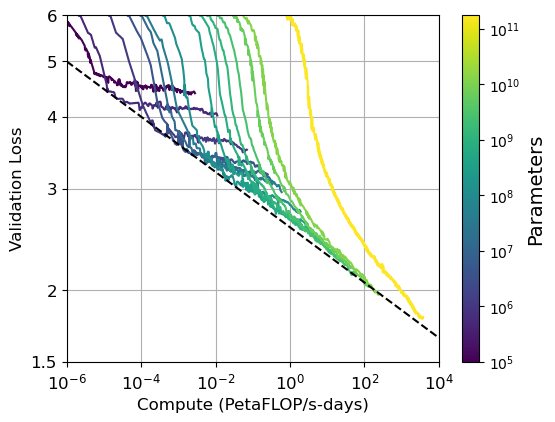

In [21]:
# fig=plt.figure(0,(6*1.09,6)) #Aspection ratio from OG plot
fig = plt.figure(0, (6, 4.5))
ax = fig.add_subplot(111)
for j in range(len(matches_mapped)):
    plt.plot(
        np.log10(matches_mapped[j][:, 0]),
        np.log10(matches_mapped[j][:, 1]),
        color=cmap(norm(np.log10(assumed_parameter_counts[j]))),
    )

plt.ylim(np.log10(1.5), np.log10(6))
plt.xlim(-6, 4)
plt.xticks(
    [-6, -4, -2, 0, 2, 4],
    ["$10^{-6}$", "$10^{-4}$", "$10^{-2}$", "$10^{0}$", "$10^{2}$", "$10^{4}$"],
    fontsize=12,
)
plt.yticks(
    np.log10(np.array([1.5, 2, 3, 4, 5, 6])),
    ["1.5", "2", "3", "4", "5", "6"],
    fontsize=12,
)

trend_x = np.logspace(-6, 4, 100)
plt.plot(np.log10(trend_x), np.log10(2.57 * trend_x**-0.048), "k--")

cbar = plt.colorbar(
    sm, ax=ax, orientation="vertical"
)  # Use 'vertical' for a vertical colorbar
cbar.set_label("Parameters", fontsize=14)
cbar.set_ticklabels(
    [
        "$10^{5}$",
        "$10^{6}$",
        "$10^{7}$",
        "$10^{8}$",
        "$10^{9}$",
        "$10^{10}$",
        "$10^{11}$",
    ]
)

plt.grid(1)
ax.set_position(
    Bbox([[0.125, 0.11], [0.745, 0.88]])
)  # Got this from ax.get_position, should help with transitions if I can keep constant.
plt.xlabel("Compute (PetaFLOP/s-days)", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
# Rendering for book
plt.savefig(
    "/Users/stephen/Stephencwelch Dropbox/welch_labs/ai_book/6_neural_scaling/graphics/gpt3-recreated.svg",
    bbox_inches="tight",
)

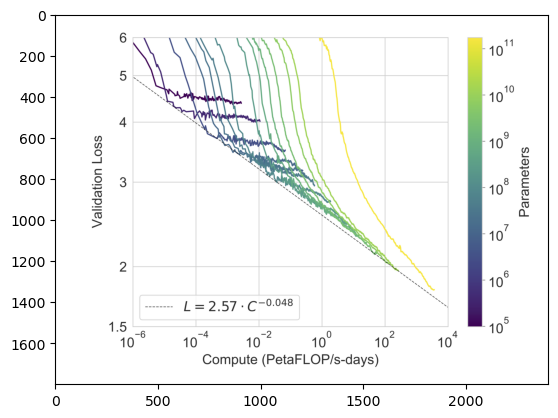

In [18]:
# Compare to original - not bad!
plt.imshow(im)

### Plot first few loss curves on non-logarithmic axis

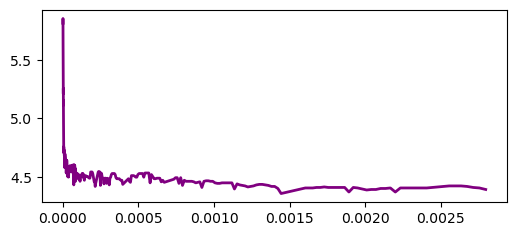

In [29]:
fig = plt.figure(0, (6, 2.5), facecolor="w")
ax = fig.add_subplot(111, facecolor="w")  #'#090B0A')

plt.plot(
    (matches_mapped[0][:, 0]),
    (matches_mapped[0][:, 1]),
    color="purple",  # cmap(norm(np.log10(assumed_parameter_counts[0]))),
    linewidth=2,
)

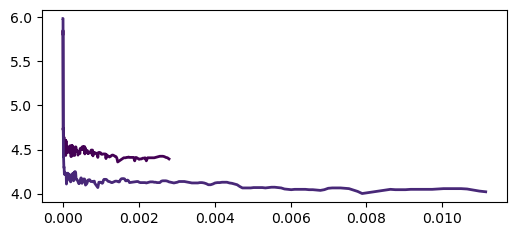

In [27]:
fig = plt.figure(0, (6, 2.5), facecolor="w")
ax = fig.add_subplot(111, facecolor="w")  #'#090B0A')

for j in range(2):
    plt.plot(
        (matches_mapped[j][:, 0]),
        (matches_mapped[j][:, 1]),
        color=cmap(norm(np.log10(assumed_parameter_counts[j]))),
        linewidth=2,
    )